## Emcee with The Transient Universe


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner


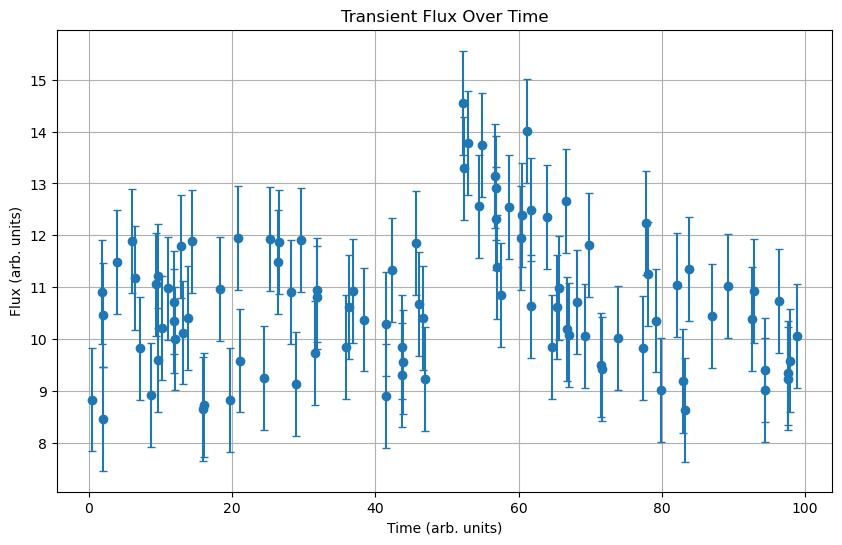

In [2]:
# Load the data
data = np.load('../solutions/transient.npy')  # Shape: (100, 3)

# Extract columns
t,y,yerr=data.T

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(t, y, yerr=yerr, fmt='o', capsize=3, label='Flux with uncertainty')
plt.xlabel('Time (arb. units)')
plt.ylabel('Flux (arb. units)')
plt.title('Transient Flux Over Time')
plt.grid(True)

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [3]:
def burst_model (theta, t):
    A,b,t_0,alpha=theta
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array

Try to fit to check

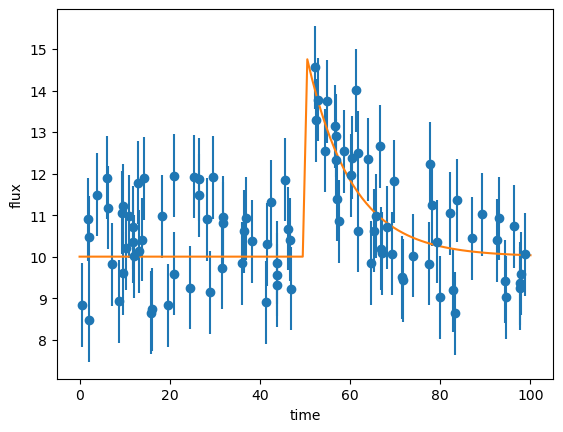

In [4]:
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1


theta_quick= np.array([A_quick, b_quick, t0_quick, alpha_quick])
ygrid =  burst_model(theta_quick, tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid);

In [5]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [6]:
def LogLikelihood(theta, data, model=burst_model): # burst_model, uncertainty(of flux), data
    x, y, yerr = data.T
    # Gaussian likelihood 
    y_fit = model(theta, x)
    return 0.5*np.sum(-(y - y_fit)**2 /yerr**2)

def LogPrior(theta):
    A,b,t0,alpha=theta
    if bmin <= b <= bmax and  Amin<= A <=Amax and t0min<= t0 <=t0max and alphamin <= alpha <= alphamax:
        return 0 + 0 + 0 - np.log(alpha) # log(1) = 0, for change of variable p(alpha) ∝ 1 / alpha --> log(p(alpha))=-log(alpha)+const
    else:
        return -np.inf # log(0) = -inf

def LogPosterior(theta, data, model=burst_model): # emcee wants a function that takes a vector in the parameter space as input
    return LogLikelihood(theta, data, model) + LogPrior(theta)



In [7]:
## Ready to use emcee

ndim = 4  # number of parameters in the model
nwalkers = 20 # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = int(1e4) # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = theta_quick  + 0.000000001*np.random.randn(nwalkers, ndim) #generates random numbers from my guess 

#-- MCMC IMPLEMENTATION ----------------------------------
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data, burst_model])
sampler.run_mcmc(starting_guesses, nsteps)

print("done")

done


Plot of trace without burn-in and thinning

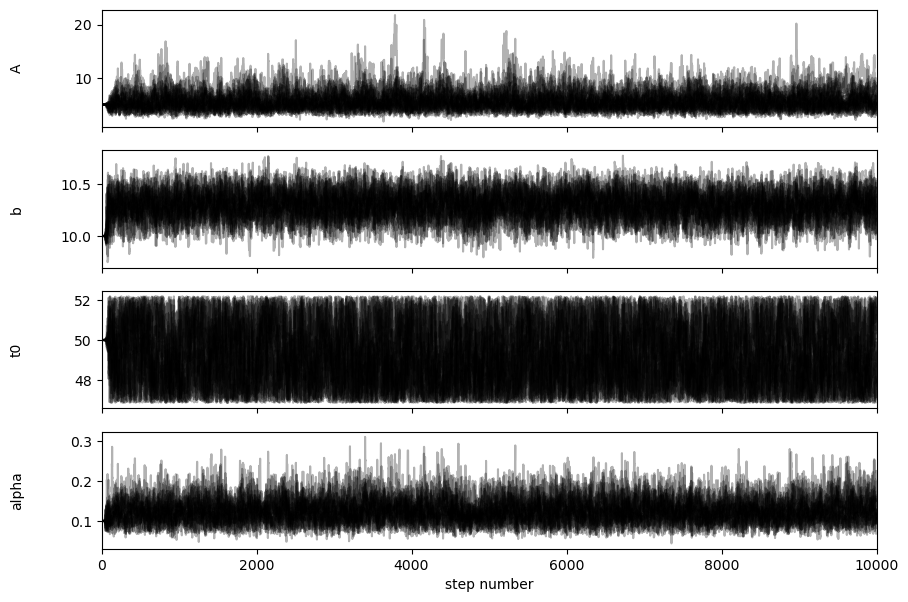

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True) # 4 vertically stacked subplots
samples = sampler.get_chain() # array[…, nwalkers, ndim]
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3) # over all steps, all walkers (:)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Burn-in: burn some points...proportional to autocorrelation lenght  
Thinning: take one point every autocorrelation lenght

In [9]:

tau = sampler.get_autocorr_time() # vector with autocorrelation times for each parameter
print(f"Autocorrelation time of each parameter", tau)

flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True) # flattens the array emcee_trace into a 1D array, discard burn point, thinning

#to understand why I use flat=true
print("Shape of output of .get_chain not flatten:", sampler.get_chain(discard=2*int(max(tau)), thin=int(max(tau))).shape, " (n steps, n walkers, parameters)")
print("Shape of output of .get_chain array flatten:", flat_samples.shape, "(nsteps x nwalkers, parameters)")

Autocorrelation time of each parameter [66.82898243 63.88598158 78.56800662 64.83459263]
Shape of output of .get_chain not flatten: (126, 20, 4)  (n steps, n walkers, parameters)
Shape of output of .get_chain array flatten: (2500, 4) (nsteps x nwalkers, parameters)


Plot of trace with burn-in and thinning

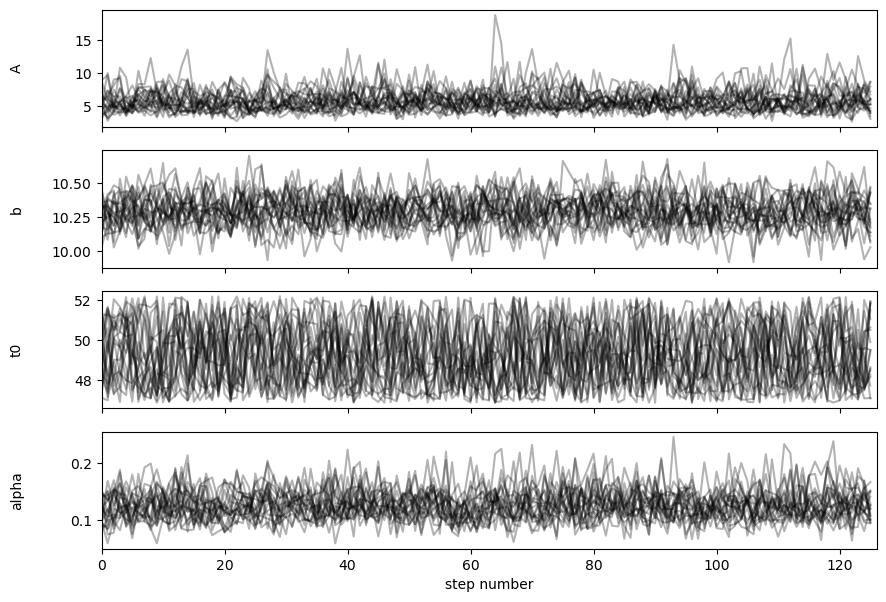

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True) # 4 vertically stacked subplots
samples = sampler.get_chain(discard=2*int(max(tau)), thin=int(max(tau)), flat=False) # array[…, nwalkers, ndim]
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3) # over all steps, all walkers (:)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

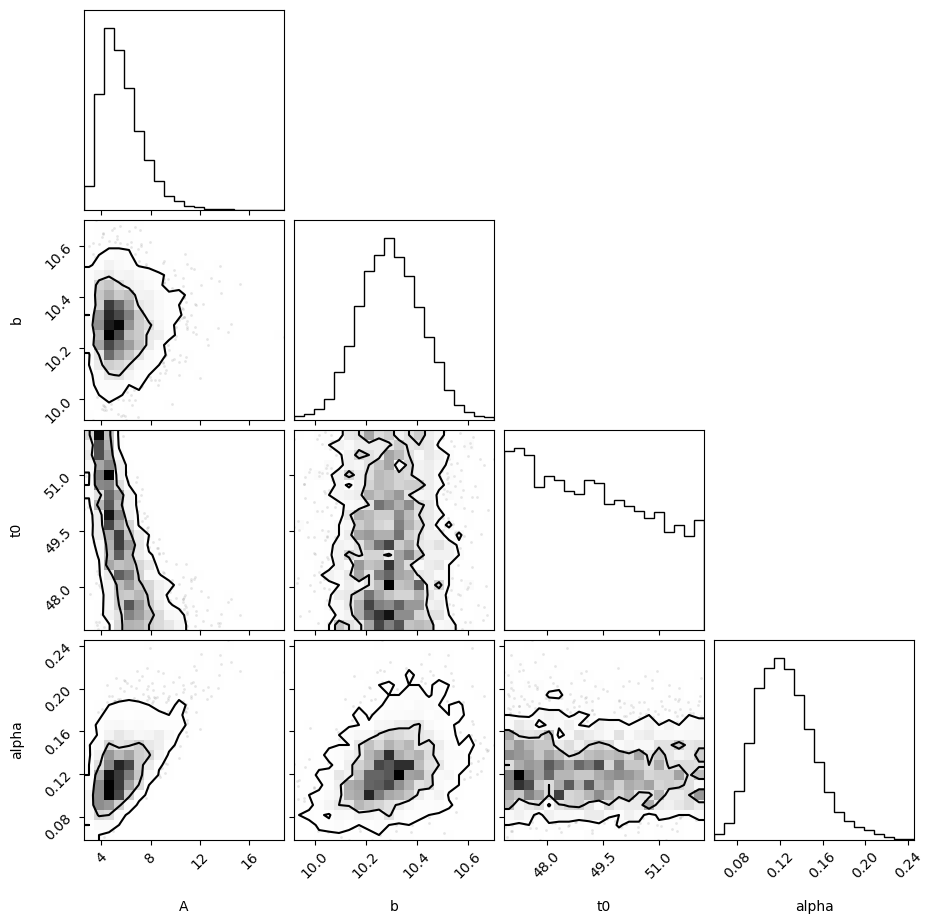

In [11]:
fig = corner.corner(
    flat_samples, # ← shape (N_samples, N_parameters)
    labels=labels, levels=[0.68,0.95]
);

Plot

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

Text(0, 0.5, 'flux')

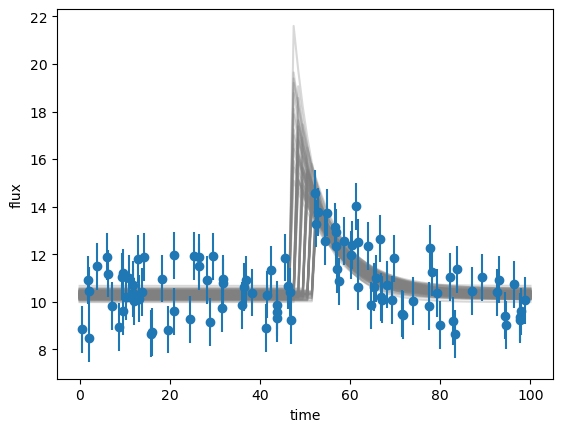

In [20]:
chosen_samples = flat_samples[np.random.choice(len(flat_samples), size=100)] # pick 100 random estimates parameters of the flat sample

tgrid=np.linspace(0,100,100)

for chosen_theta in chosen_samples:

    chosen_y = burst_model(chosen_theta, tgrid)
    plt.plot(tgrid, chosen_y, alpha=0.3, c='gray')

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")





7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [25]:
print("\t Median \t Low-level \t\t Up-level of 90% credible region")

for i,l in enumerate(labels):
    low,med, up = np.percentile(flat_samples[:,i],[5,50,95]) # Gets 5th, 50th (median), and 95th percentiles
    print(l+"   "+str(med)+"\t +"+str(up-med)+"\t -"+str(med-low))

	 Median 	 Low-level 		 Up-level of 90% credible region
A   5.407876810174336	 +3.453530960556746	 -1.792720144067017
b   10.294718588965619	 +0.20084390798797358	 -0.19372237478984644
t0   49.14693890256822	 +2.731467091061738	 -2.083350863089784
alpha   0.12295782525123279	 +0.05220198702072136	 -0.03745472402707643
